In [6]:
# Standard
import os

# Third-party
import deepchem as dc
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from optuna.samplers import TPESampler
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.model_selection import cross_val_score

# Own-coded
from measurements import nRMSE
from utils import get_similarity, load_bace

# Make all the figures have Times New Roman font, and 16 font size
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16


# Studying Ways of visualization and featurization of SMILES strings

In [34]:
featurizer = 'ECFP'
_, bace_datasets, _ = dc.molnet.load_bace_regression(featurizer=featurizer,
                                                     splitter = dc.splits.RandomSplitter())


In [2]:
# Load BACE regression dataset
df_train, df_valid, df_test = load_bace(splitter = dc.splits.RandomSplitter())
smiles = df_train.smiles.values.tolist()
similarity_matrix, fingerprints, mols = get_similarity(smiles)
df = pd.DataFrame(similarity_matrix, index=smiles, columns=smiles)

df_train = df_train.set_index('smiles')
df_valid = df_valid.set_index('smiles')
df_test = df_test.set_index('smiles')


## A simple Model:

In [3]:
# Now it's time to train a Linear Regression model with the Fingerprints
# Let's use the Linear Regression model from sklearn

# Train the model
X = df_train.drop(columns=['targets'])
y = df_train.targets.values
x_valid = df_valid.drop(columns=['targets'])
y_valid = df_valid.targets.values
# X and x_valid are the new X_train
# y and y_valid are the new y_train
X_train = pd.concat([X, x_valid])
y_train = np.concatenate([y, y_valid])
x_test = df_test.drop(columns=['targets'])
y_test = df_test.targets.values

X_train = pd.concat([X, x_valid, x_test])
y_train = np.concatenate([y, y_valid, y_test])

# Initial models:

## Optuna search, Lasso:

Here we will be performing hyperparameter optimization for the Lasso Regression

In [8]:
def objective(trial):
    # Alpha is the regularization parameter
    # the bigger it is, the the more the model will be penalized
    # 
    # The objective is: (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1
    # 
    # Alpha shall be between 0 and 10000 and it will be chosen in a log scale
    alpha = trial.suggest_float('alpha', 1e-4, .1)
    # Cross-validate the model
    reg = Lasso(alpha=alpha, max_iter=int(1e4))
    # Perform cross-validation
    scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='r2')
    

    return np.mean(scores)

sampler = TPESampler(seed=10)
study = optuna.create_study(direction='maximize', sampler=sampler,
                            study_name='lasso')
study.optimize(objective, n_trials=100, n_jobs=-1)
print(study.best_params)
print(study.best_value)
print(study.best_trial)


[I 2024-09-07 17:36:26,209] A new study created in memory with name: lasso
/Users/cesarasa/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2024-09-07 17:36:27,162] Trial 0 finished with value: 0.24827046021128668 and parameters: {'alpha': 0.05657297653046675}. Best is trial 0 with value: 0.24827046021128668.
[I 2024-09-07 17:36:27,271] Trial 2 finished with value: 0.12721052547400563 and parameters: {'alpha': 0.08217403408199311}. Best is trial 0 with value: 0.24827046021128668.
[I 2024-09-07 17:36:27,644] Trial 5 finished with value: 0.11463022441134214 and parameters: {'alpha': 0.0867844644646895}. Best is trial 0 with value: 0.24827046021128668.
[I 2024-09-07 17:36:27,821] Trial 4 finished with value: 0.14274087314479172 and parameters: {'alpha': 0.07698932700073323}. Bes

{'alpha': 0.002138955437672642}
0.6815455513252523
FrozenTrial(number=94, values=[0.6815455513252523], datetime_start=datetime.datetime(2024, 9, 7, 17, 38, 26, 421610), datetime_complete=datetime.datetime(2024, 9, 7, 17, 38, 38, 16204), params={'alpha': 0.002138955437672642}, distributions={'alpha': UniformDistribution(high=0.1, low=0.0001)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=94, state=TrialState.COMPLETE, value=None)


Train nRMSE: 0.4502
Test nRMSE: 0.4224
Train R2: 0.7973
Test R2: 0.8216
Train PCC: 0.8953
Test PCC: 0.9112


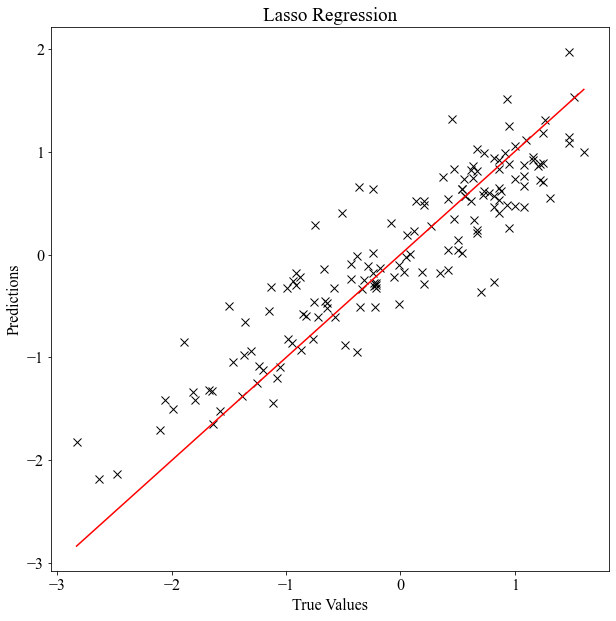

In [7]:
X_train = pd.concat([X, x_valid, x_test])
y_train = np.concatenate([y, y_valid, y_test])

# Train with X_train and y_train, using best parameters:
reg = Lasso(alpha=0.002, max_iter=int(1e4))
reg.fit(X_train, y_train)

# Predict and compute the nRMSE for train and test set
y_pred_train = reg.predict(X_train)
nrmse, r2, mse, rmse = nRMSE(y_train, y_pred_train)

y_pred_test = reg.predict(x_test)
nrmse_test, r2_test, mse_test, rmse_test = nRMSE(y_test, y_pred_test)

# Print:
print(f'Train nRMSE: {nrmse:.4f}')
print(f'Test nRMSE: {nrmse_test:.4f}')
print(f'Train R2: {r2:.4f}')
print(f'Test R2: {r2_test:.4f}')
# Print PCC
pcc = np.corrcoef(y_train, y_pred_train)[0, 1]
print(f'Train PCC: {pcc:.4f}')
pcc_test = np.corrcoef(y_test, y_pred_test)[0, 1]
print(f'Test PCC: {pcc_test:.4f}')

# Plot predictions vs true values
plt.figure(figsize=(10, 10))
plt.plot(y_test, y_pred_test, 'kx', markersize=8)
# Plot line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Lasso Regression')

# Create figures folder
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig('figures/lasso_regression_plot.png')
plt.show()

## Optuna search, Ridge

Here we sill be performing HPO for the Ridge Regression. 

In [41]:
def objective(trial):
    # Alpha is the regularization parameter
    # the bigger it is, the the more the model will be penalized
    # 
    # The objective is: (1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1
    # 
    # Alpha shall be between 0 and 10000 and it will be chosen in a log scale
    alpha = trial.suggest_float('alpha', 1e-1, 100)
    # Cross-validate the model
    reg = Ridge(alpha=alpha, max_iter=int(1e4))
    # Perform cross-validation
    scores = cross_val_score(reg, X_train, y_train, cv=5, scoring='r2')
    

    return np.mean(scores)

sampler = TPESampler(seed=10)
study2 = optuna.create_study(direction='maximize', sampler=sampler,
                            study_name='ridge')
study2.optimize(objective, n_trials=100, n_jobs=-1)
print(study2.best_params)
print(study2.best_value)
print(study2.best_trial)

[I 2024-09-07 18:11:28,317] A new study created in memory with name: ridge
/Users/cesarasa/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/optuna/study/study.py:393: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  warnings.warn(
[I 2024-09-07 18:11:33,219] Trial 2 finished with value: 0.6663889593069705 and parameters: {'alpha': 56.30937443947883}. Best is trial 2 with value: 0.6663889593069705.
[I 2024-09-07 18:11:33,273] Trial 5 finished with value: 0.6468160943561039 and parameters: {'alpha': 87.28496677794529}. Best is trial 2 with value: 0.6663889593069705.
[I 2024-09-07 18:11:33,422] Trial 6 finished with value: 0.6741179841893136 and parameters: {'alpha': 44.29907697466975}. Best is trial 6 with value: 0.6741179841893136.
[I 2024-09-07 18:11:33,441] Trial 8 finished with value: 0.6555871591671641 and parameters: {'alpha': 73.1584190382961}. Best is trial 6 wi

{'alpha': 17.698504382055294}
0.6867049811200541
FrozenTrial(number=31, values=[0.6867049811200541], datetime_start=datetime.datetime(2024, 9, 7, 18, 11, 42, 32506), datetime_complete=datetime.datetime(2024, 9, 7, 18, 11, 45, 805956), params={'alpha': 17.698504382055294}, distributions={'alpha': UniformDistribution(high=100.0, low=0.1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=31, state=TrialState.COMPLETE, value=None)


Train nRMSE: 0.3874
Test nRMSE: 0.3672
Train R2: 0.8499
Test R2: 0.8652
Train PCC: 0.9244
Test PCC: 0.9332


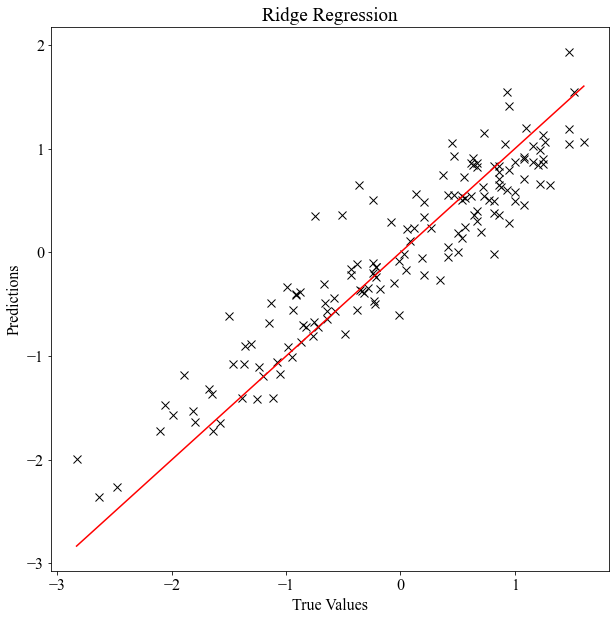

In [8]:
X_train = pd.concat([X, x_valid, x_test])
y_train = np.concatenate([y, y_valid, y_test])
# Train with X_train and y_train, using best parameters:
reg2 = Ridge(alpha=15, max_iter=int(1e4))
reg2.fit(X_train, y_train)

# Predict and compute the nRMSE for train and test set
y_pred_train = reg2.predict(X_train)
nrmse, r2, mse, rmse = nRMSE(y_train, y_pred_train)

y_pred_test = reg2.predict(x_test)
nrmse_test, r2_test, mse_test, rmse_test = nRMSE(y_test, y_pred_test)

# Print:
print(f'Train nRMSE: {nrmse:.4f}')
print(f'Test nRMSE: {nrmse_test:.4f}')
print(f'Train R2: {r2:.4f}')
print(f'Test R2: {r2_test:.4f}')
pcc = np.corrcoef(y_train, y_pred_train)[0, 1]
print(f'Train PCC: {pcc:.4f}')
pcc_test = np.corrcoef(y_test, y_pred_test)[0, 1]
print(f'Test PCC: {pcc_test:.4f}')


# Plot predictions vs true values
plt.figure(figsize=(10, 10))
plt.plot(y_test, y_pred_test, 'kx', markersize=8)
# Plot line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Ridge Regression')
plt.savefig('figures/ridge_regression_plot.png')
plt.show()

Train nRMSE: 0.2365
Test nRMSE: 0.2513
Train R2: 0.9440
Test R2: 0.9369
Train PCC: 0.9716
Test PCC: 0.9680


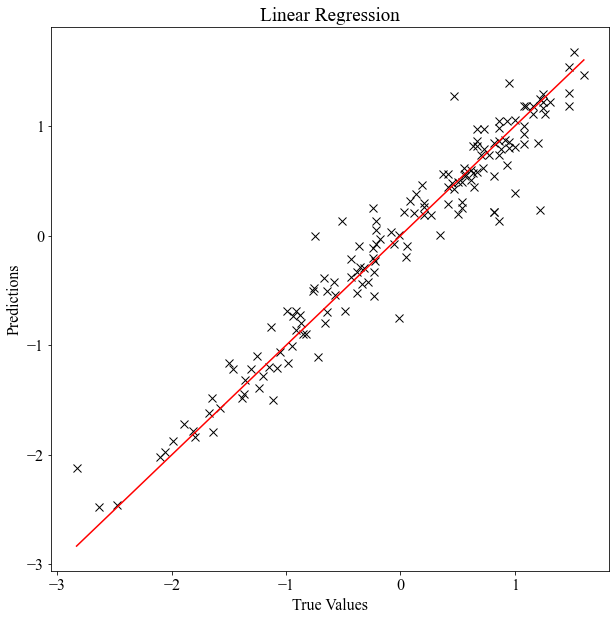

In [9]:
# Linear Regression:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict and compute the nRMSE for train and test set
y_pred_train = lr.predict(X_train)
nrmse, r2, mse, rmse = nRMSE(y_train, y_pred_train)

y_pred_test = lr.predict(x_test)
nrmse_test, r2_test, mse_test, rmse_test = nRMSE(y_test, y_pred_test)

# Print:
print(f'Train nRMSE: {nrmse:.4f}')
print(f'Test nRMSE: {nrmse_test:.4f}')
print(f'Train R2: {r2:.4f}')
print(f'Test R2: {r2_test:.4f}')
pcc = np.corrcoef(y_train, y_pred_train)[0, 1]
print(f'Train PCC: {pcc:.4f}')
pcc_test = np.corrcoef(y_test, y_pred_test)[0, 1]
print(f'Test PCC: {pcc_test:.4f}')

# Plot predictions vs true values
plt.figure(figsize=(10, 10))
plt.plot(y_test, y_pred_test, 'kx', markersize=8)
# Plot line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Linear Regression')
plt.savefig('figures/linear_regression_plot.png')
plt.show()